In [1]:
import torch
from torch import nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from torch.utils.data import DataLoader, Subset

# 🧠 **Many Men vs Iron Man** 🧠

### Welcome to an Lesson 03! 🚀

In this notebook, we will pit an ensemble of 3 neural networks 👫👫👫 against 1 big neural network 💪 to see which performs better at identifying the state (REM, wakeful, deep) of a 10-second long segment of data.

Our data comes from **rats** 🐀 and includes 10-second long segments that are classified into one of three states: REM, wakeful, or deep sleep. By comparing these two approaches, we aim to determine whether the combined wisdom of many smaller models or the sheer power of a single large model will triumph.

Will the collective intelligence of many prevail, or will the might of a lone giant come out on top? Let's dive in and find out! 🔍⚡

In [2]:
DATA_FOLDER = './../data/rat_eeg'


files = [f for f in os.listdir(DATA_FOLDER) if f.endswith('.pt')]

all_data = []
for file in files:
    path = os.path.join(DATA_FOLDER, file)
    data = torch.load(path)
    all_data.append((data[0], data[1]))

# split  into train and test sets
train_data, test_data = train_test_split(all_data, test_size=2/6, random_state=42)

# concat to creat full set
X_train = torch.cat([data[0] for data in train_data])
y_train = torch.cat([data[1] for data in train_data])

X_test = torch.cat([data[0] for data in test_data])
y_test = torch.cat([data[1] for data in test_data])

print(f"Training  X: {X_train.shape}")
print(f"Training  y: {y_train.shape}\n")

print(f"Test X: {X_test.shape}")
print(f"Test y: {y_test.shape}")


Training  X: torch.Size([34560, 1000])
Training  y: torch.Size([34560, 3])

Test X: torch.Size([17280, 1000])
Test y: torch.Size([17280, 3])


### 🎵 Side Note 🎵

Can we code this whole thing up while listening to nothing but "Many Men"? 🤔🎶 I don't know, but I will keep you updated at eh end of the note book!


### ☯️ **Remember: Become One with the Data** ☯️

So let's take a look at some of it. 📊🔍


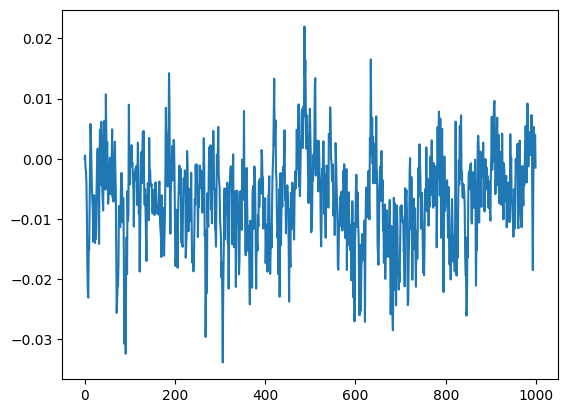

In [557]:
plt.plot(X_train[0])

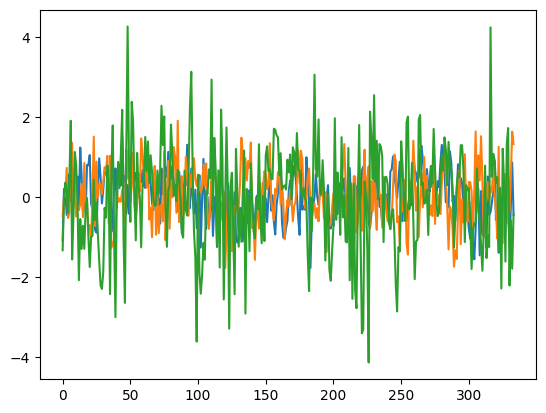

In [558]:
plt.plot(X_train[50, ::3]) #the  ::3 just plots ever 3 points
plt.plot(X_train[100, ::3])
plt.plot(X_train[1000, ::3])

In [559]:
y_train.argmax(axis=1).bincount() #coun of each lable

tensor([ 1782, 14050, 18728])

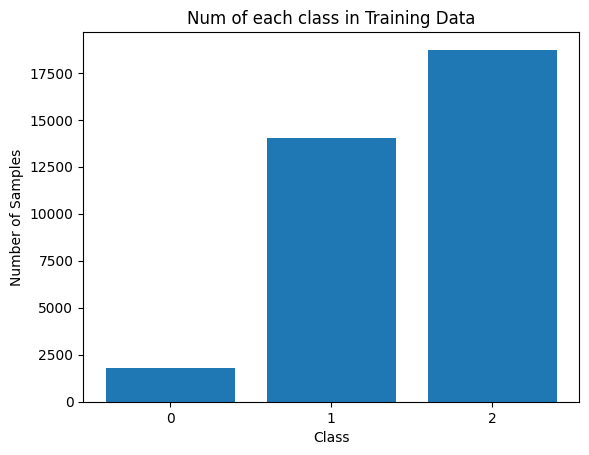

In [560]:
#so the range(len([?,?,?])) makes it such that there are 3 bins then second arg is the values in each bin
range_0_3 = range(len(y_train.argmax(axis=1).bincount()))

plt.bar(range_0_3, (y_train.argmax(axis=1).bincount()).numpy())

plt.title('Num of each class in Training Data');
plt.xlabel('Class');
plt.ylabel('Number of Samples');
plt.xticks(range_0_3);

### ⚖️ **The Issue of Unbalanced Data in ML** ⚖️

Our labels are not equal, which is a very big issue (☠️ some call it death ☠️) in machine learning. When we have a lot more of one type than another, we might classify everything as the dominant class because there's no penalty for getting the less frequent class wrong. This issue is inherent to our data, where class 0 (REM) is significantly underrepresented.

To address this, we will remove some samples from classes 1 and 2 to balance the dataset. There are many ways to solve this issue, but we will take this approach this time. However, note that deep learning fundamentally requires lots of data, so remove data cautiously. 🚨

Let's proceed and fix this imbalance! 🛠️

### 🚫 **No Augmentation for the Test Set** 🚫

It's important to note that we will not augment the test set in any way. This is because, in the real world, we would receive the data as it is, and we don't want to affect how we evaluate our performance. 📊🔍

Let's ensure our evaluation remains realistic and unbiased! ✅


In [561]:
#list of 3 tensors each tensor is the indices were the y_tarin is class = 0 then next tensor is the indices were the y_tarin is class = 1 etc........
class_indices = [torch.where(y_train.argmax(dim=1) == i)[0] for i in range(3)] 


max_samples = 1782  # num of REM samples

#of all the class 1 indices we do a random permutation then we get the first 1782 of the permutaion this now represents all the indices of the samples in the data set
class_indices[1] = class_indices[1][torch.randperm(len(class_indices[1]))[:max_samples]] 

#do the saw for class 2 
class_indices[2] = class_indices[2][torch.randperm(len(class_indices[2]))[:max_samples]]


print('count of each index is:')
len(class_indices[0]), len(class_indices[1]), len(class_indices[2])

count of each index is:


(1782, 1782, 1782)

In [562]:
balanced_indices = torch.cat(class_indices) #combine all of them 

# suffle then so the trian set is NOT jsut all rem then all class 1 then all class 2
balanced_indices = balanced_indices[torch.randperm(len(balanced_indices))]

# make the balanced datasets
X_train = X_train[balanced_indices]
y_train = y_train[balanced_indices]

print("new class counts:")
print(y_train.argmax(dim=1).bincount())

print(f"\nBalanced X_test shape: {X_train.shape}")
print(f"Balanced y_test shape: {y_train.shape}")

new class counts:
tensor([1782, 1782, 1782])

Balanced X_test shape: torch.Size([5346, 1000])
Balanced y_test shape: torch.Size([5346, 3])


### 🤔 **Less Data: A Good Idea?** 🤔

So, we have a lot less data now, and this might not have been a great idea. There are arguments both for and against this approach, but let's keep exploring and see what we find. 🔍

Stay curious and let's dive deeper! 🚀


So first, let's create a test neural network to see if we can memorize the data. 🧠💾

Remember over over fit first

In [563]:
class MLP_TESTER(nn.Module):
    def __init__(self):
        super(MLP_TESTER, self).__init__()
        self.l0  = nn.Linear(1000, 500)
        self.relu0 = nn.ReLU()

        self.l1  = nn.Linear(500, 100)
        self.relu1 = nn.ReLU()

        self.l2  = nn.Linear(100, 32)
        self.relu2 = nn.ReLU()

        self.l3  = nn.Linear(32, 32)
        self.relu3 = nn.ReLU()

        self.l4  = nn.Linear(32, 32)
        self.relu4 = nn.ReLU()

        self.l5  = nn.Linear(32, 32)
        self.relu5 = nn.ReLU()

        self.l6  = nn.Linear(32, 3)
        self.out = nn.Sigmoid()


    def forward(self, X):
        x = self.l0(X)
        x = self.relu0(x)
        x = self.l1(x)
        x = self.relu1(x)
        x = self.l2(x)
        x = self.relu2(x)
        x = self.l3(x)
        x = self.relu3(x)
        x = self.l4(x)
        x = self.relu4(x)
        x = self.l5(x)
        x = self.relu5(x)
        logits = self.l6(x)
        out = self.out(logits)
        return out

mlp_tester = MLP_TESTER()
optimizer = torch.optim.Adam(params=mlp_tester.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()

100%|██████████| 500/500 [00:11<00:00, 44.39it/s]


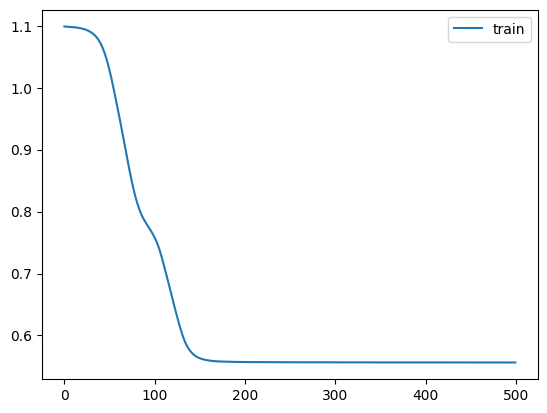

In [564]:
lossi = []

for epoch in tqdm(range(500)):
    out = mlp_tester.forward(X_train)

    optimizer.zero_grad()
    loss = criterion(out, y_train)

    loss.backward()
    lossi.append(loss.item())
    optimizer.step()

plt.plot(lossi, label='train')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1782
           1       1.00      0.99      0.99      1782
           2       0.99      1.00      0.99      1782

    accuracy                           1.00      5346
   macro avg       1.00      1.00      1.00      5346
weighted avg       1.00      1.00      1.00      5346



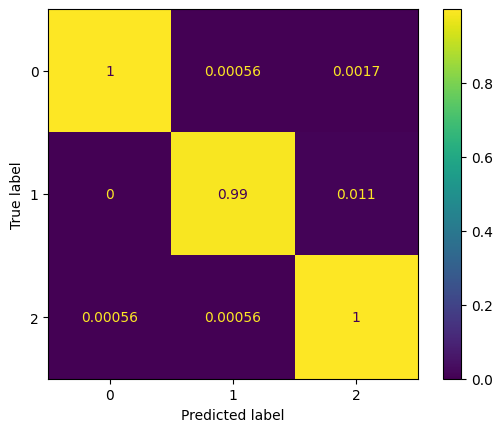

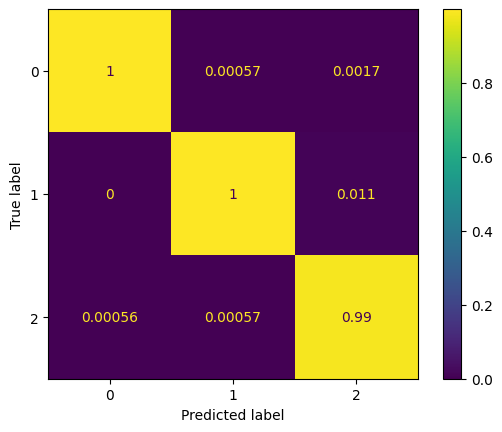

In [565]:
y_pred = mlp_tester.forward(X_train).argmax(axis=1);
y_true = y_train.argmax(axis=1);

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='true');

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='pred');

print(classification_report(y_true=y_true, y_pred=y_pred));

### 🦾 **Iron Man Model: Let's Build It!** 🦾

Okay, perfect! We've overfitted the test model as intended. Now, let's make Iron Man.

We will use the same structure for Iron Man but introduce dropout with a rate of 0.3 to prevent overfitting and see if we can generalize better to the test set. Dropout is often compared to ensemble methods since we are dropping weights, effectively creating infinitely many different neural networks during training. I will make a lesson explaining dropout better sometime.

Let's get building! 🔨👷‍♂️


📌 **Note on Boosting the Dataset** 📌

To get the best results, we should bootstrap the dataset. This means each of the models in the ensemble is trained on a subset of the dataset that is created from the original dataset via sampling with replacement. This approach gives the ensemble a lot more "power," so to speak. We are skipping over it for now but will come back to it later. 📈💪

Stay tuned for more! 🔄

In [661]:
class IRONMAN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(IRONMAN, self).__init__()
        self.l0 = nn.Linear(1000, 256)
        self.relu0 = nn.ReLU()
        self.dropout0 = nn.Dropout(dropout_rate)
        
        self.l1 = nn.Linear(256, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.l2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.l3 = nn.Linear(32, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.l4 = nn.Linear(32, 32)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_rate)
        
        self.l5 = nn.Linear(32, 32)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(dropout_rate)

        self.l6 = nn.Linear(32, 3)
        self.out = nn.Sigmoid()

    def forward(self, X):
        x = self.dropout0(self.relu0(self.l0(X)))
        x = self.dropout1(self.relu1(self.l1(x)))
        x = self.dropout2(self.relu2(self.l2(x)))
        x = self.dropout3(self.relu3(self.l3(x)))
        x = self.dropout4(self.relu4(self.l4(x)))
        x = self.dropout5(self.relu5(self.l5(x)))
        logits = self.l6(x)
        x = self.out(logits)
        return x


ironman = IRONMAN()
optimizer = torch.optim.AdamW(params=ironman.parameters(), lr=0.0003, weight_decay=0.02)
criterion = nn.CrossEntropyLoss()

100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


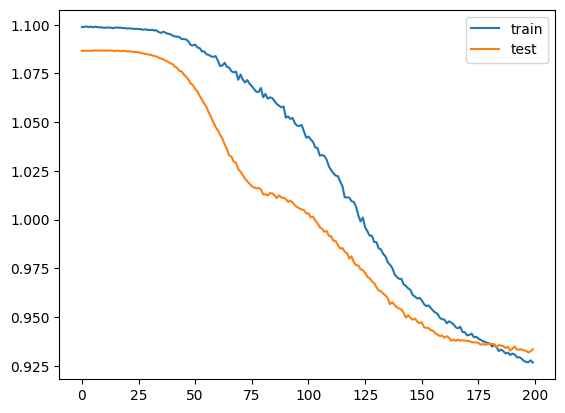

In [662]:
lossi = []
devlossi = []
f1 = []
devf1 = []

for epoch in tqdm(range(200)):
    out = ironman.forward(X_train)

    optimizer.zero_grad()
    loss = criterion(out, y_train)

    loss.backward()
    lossi.append(loss.item())
    optimizer.step()
    
    with torch.no_grad():
        devout = ironman.forward(X_test)
        devloss  = criterion(devout, y_test)
        devlossi.append(devloss.item())
    
    if epoch % 2:
        plt.close()
        plt.plot(lossi, label='train')
        plt.plot(devlossi, label='test')
        plt.legend()
        plt.savefig("loss.png")



In [663]:
min(lossi), min(devlossi)

(0.9266532063484192, 0.9318261742591858)

              precision    recall  f1-score   support

           0       0.23      0.30      0.26      1075
           1       0.53      0.63      0.57      8122
           2       0.50      0.38      0.43      8083

    accuracy                           0.49     17280
   macro avg       0.42      0.44      0.42     17280
weighted avg       0.50      0.49      0.49     17280



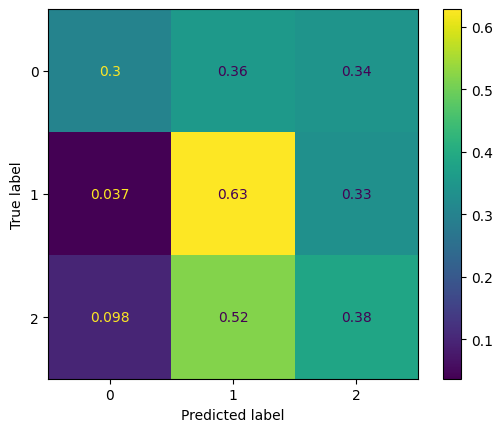

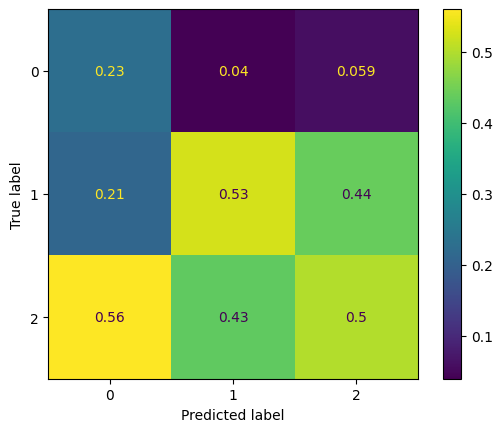

In [664]:
with torch.no_grad():
    y_pred = ironman.forward(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='true')

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='pred')


print(classification_report(y_true=y_true, y_pred=y_pred))


### **Iron Man Model Results** 🦾📊

Alright, so we have an F1 score of **42/100** on our test set. While this is definitely not a great result, we will see if Many Men can do better at generalizing.

When looking at the confusion matrix, you can see that the tough cookie to crack is the distinction between label 0 (REM) and label 2 (deep sleep).

The first confusion matrix is normalized across true values so you can see that, of all the instances that are truly class 0, we predicted them as class 0 only **30%** of the time.

And for the predicted 0 labels, we see that **56%** of the time they are actually class 2.

Let's see if Many Men can improve on these results! 👥💪


In [3]:
class MANYMEN(nn.Module):
    def __init__(self):
        super(MANYMEN, self).__init__()
        self.l0 = nn.Linear(1000, 64)
        self.relu0 = nn.ReLU()
        
        self.l1 = nn.Linear(64, 64)
        self.relu1 = nn.ReLU()
        
        self.l2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        

        self.l3 = nn.Linear(32, 3)
        self.out = nn.Sigmoid()

    def forward(self, X):
        x = self.relu0(self.l0(X))
        x = self.relu1(self.l1(x))
        x = self.relu2(self.l2(x))
        logits = self.l3(x)
        x = self.out(logits)
        return x


man00 = MANYMEN()
optimizer00 = torch.optim.AdamW(params=man00.parameters(), lr=0.0003, weight_decay=0.02)


criterion = nn.CrossEntropyLoss()

100%|██████████| 120/120 [00:04<00:00, 29.15it/s]


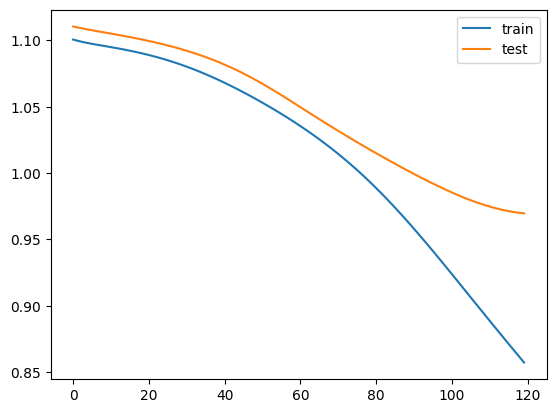

In [814]:
lossi = []
devlossi = []

for epoch in tqdm(range(120)):
    out0 = man00.forward(X_train)



    optimizer00.zero_grad()


    loss0 = criterion(out0, y_train)

    loss0.backward()


    loss = criterion(out0,y_train)
    lossi.append(loss.item())

    optimizer00.step()

    
    with torch.no_grad():
        devout0 = man00.forward(X_test)

        devloss = criterion(devout0, y_test)
        devlossi.append(devloss.item())
    
    if epoch % 2:
        plt.close()
        plt.plot(lossi, label='train')
        plt.plot(devlossi, label='test')

        plt.legend()
        plt.savefig("loss.png")

In [815]:
man01 = MANYMEN()
optimizer01 = torch.optim.AdamW(params=man01.parameters(), lr=0.0003, weight_decay=0.02)

100%|██████████| 120/120 [00:04<00:00, 26.15it/s]


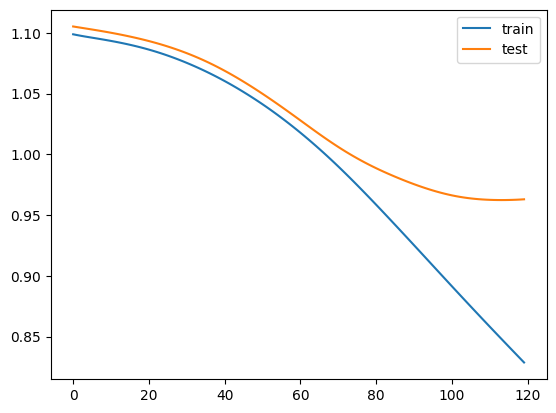

In [816]:
lossi = []
devlossi = []

for epoch in tqdm(range(120)):
    out1 = man01.forward(X_train)


    optimizer01.zero_grad()

    loss1 = criterion(out1, y_train)


    loss1.backward()

    loss = criterion(out1,y_train)
    lossi.append(loss.item())

    optimizer01.step()

    
    with torch.no_grad():
        devout1 = man01.forward(X_test)
        devloss = criterion(devout1, y_test)
        devlossi.append(devloss.item())
    
    if epoch % 2:
        plt.close()
        plt.plot(lossi, label='train')
        plt.plot(devlossi, label='test')

        plt.legend()
        plt.savefig("loss.png")

In [817]:
man02 = MANYMEN()
optimizer02 = torch.optim.AdamW(params=man02.parameters(), lr=0.0003, weight_decay=0.02)

100%|██████████| 125/125 [00:04<00:00, 25.81it/s]


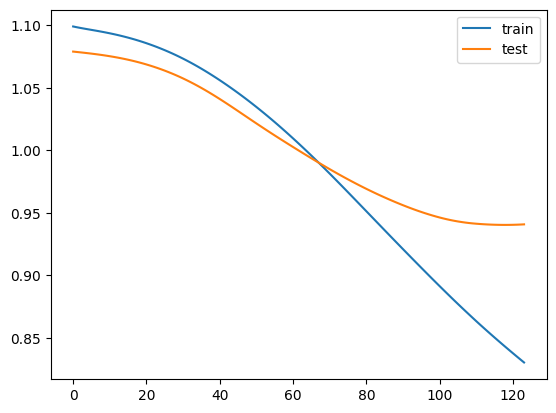

In [818]:
lossi = []
devlossi = []

for epoch in tqdm(range(125)):
    out2 = man02.forward(X_train)


    optimizer02.zero_grad()

    loss2 = criterion(out2, y_train)


    loss2.backward()

    loss = criterion(out2,y_train)
    lossi.append(loss.item())

    optimizer02.step()

    
    with torch.no_grad():
        devout1 = man02.forward(X_test)
        devloss = criterion(devout1, y_test)
        devlossi.append(devloss.item())
    
    if epoch % 2:
        plt.close()
        plt.plot(lossi, label='train')
        plt.plot(devlossi, label='test')

        plt.legend()
        plt.savefig("loss.png")

              precision    recall  f1-score   support

           0       0.26      0.04      0.07      1075
           1       0.59      0.75      0.66      8122
           2       0.67      0.56      0.61      8083

    accuracy                           0.62     17280
   macro avg       0.51      0.45      0.45     17280
weighted avg       0.61      0.62      0.60     17280



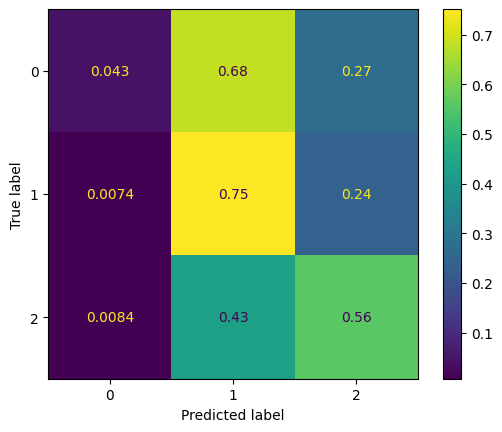

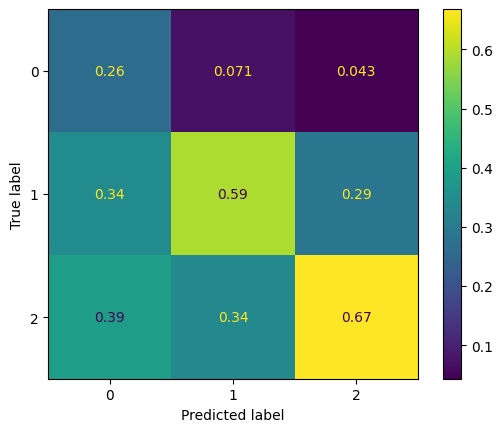

In [820]:
with torch.no_grad():
    pred0 = man00.forward(X_test).argmax(axis=1)
    pred1 = man01.forward(X_test).argmax(axis=1)
    pred2 = man02.forward(X_test).argmax(axis=1)
    y_pred = ((pred0 + pred1 + pred2)/3).round()
    y_true = y_test.argmax(axis=1)

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='true')

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='pred')


print(classification_report(y_true=y_true, y_pred=y_pred))


In [719]:
#params in iron man
print(sum(p.numel() for p in ironman.parameters()))

278051


In [720]:
#params in each of the 3 men
print(sum(p.numel() for p in man00.parameters()))

70403


### **Ensemble Results: A Step Up** 📊🔝

So, we achieved better results with the real ensemble: **45/100** F1 score compared to **42/100** with Iron Man. However, it's worth noting that each of our 3 Many Men models had **70,403 parameters**, compared to the **278,051** in the Iron Man model. If you do the math, you'll see that our Many Men model (the sum of the three ensemble models) actually has **30% more parameters** than the Iron Man model. 📈🤖 Now, this isn't that important as I trained Ironman with many more parameters and it did not do much better at all.

Now, the question is, why not always use an ensemble rather than dropout? 🤔

Well, true ensembling is very costly. You need separate models, and you have to train each one, which can get very computationally inefficient, especially with large models. So, while true ensembling can improve performance, it comes at a computational cost. 💡

But the cost of dropout can be computationally less expensive and allows you to approximate true ensembling. By choosing to 'turn off' a set of inputs for each training example at each layer, we are effectively creating a mini-model for each subset we train on. For the next subset, we turn on/off a different set of neurons in the layers. This, in effect, creates sub-models at each step, like true ensembling. However, note that these models are not truly independent but instead share weights since it's still one big model.

> **Note:**
> 
> "Though the cost per-step of applying dropout to a specific model is negligible,
> the cost of using dropout in a complete system can be significant. Because dropout
> is a regularization technique, it reduces the effective capacity of a model. To offset
> this effect, we must increase the size of the model. Typically the optimal validation
> set error is much lower when using dropout, but this comes at the cost of a much
> larger model and many more iterations of the training algorithm."
> 
> — *Deep Learning*, Ian Goodfellow, Yoshua Bengio, and Aaron Courville, MIT Press, 2016, page 265.


<br>
</br>

### **Why Does This Work?** 🔍🤔

Now, why does this work? So, true ensamble works because, since we have different models initialized, they will start in different places in the loss landscape and if we bootstrap the data too the models each will see slightly different data at each step. Then as a result they will likely end up in different minima at the end of training, meaning that they are not making the same mistakes on the test set. So, the sum of their knowledge will result in a better model.

In the case of dropout, when we are turning off a whole neuron, we are creating smart noise. Say that neuron was in charge of identifying a nose in an image of a person. If we turn it off, then the model has to learn to rely on other neurons, either by encoding the nose feature again in a different neuron or by being able to find a face with other features too. This kind of smart destruction will, as you can imagine, lead our model to have better generalization. 🌟📉


### **Great Lesson, But Let's Go Further!** 🚀

All we really did was compare 3 small models vs one big one, all trained on the same big set of data. Now, let's try this again but with **bagging** on our dataset.


### **How Will We Do This?** 🤔

First, for the **Many Men model**, we will create **3 datasets** via sampling from the main dataset to train each model on. 

Then, for the **Iron Man model**, we will use **mini-batching**. We will explain this more in depth


In [822]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
print(sum([p.numel() for p in ironman.parameters()]))

557099


In [835]:
ironman = IRONMAN()
optimizer = torch.optim.AdamW(params=ironman.parameters(), lr=0.0003, weight_decay=0.02)
criterion = nn.CrossEntropyLoss()

100%|██████████| 500/500 [02:10<00:00,  3.83it/s]


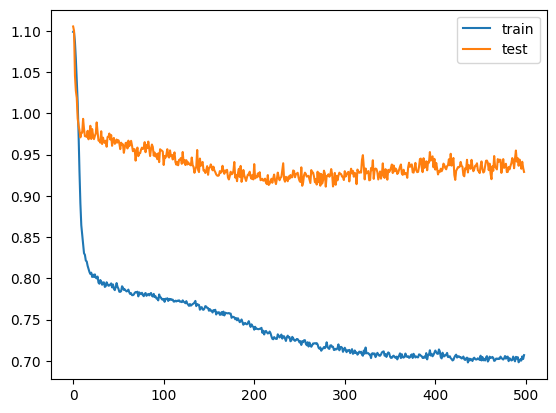

In [836]:
lossi = []
devlossi = []

train_dataset = TensorDataset(X_train, y_train)
batch_size = 64  #num examples in each batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in tqdm(range(500)):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        out = ironman.forward(X_batch)
        
        optimizer.zero_grad()
        loss = criterion(out, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    lossi.append(epoch_loss / len(train_loader))  # append avg loss per epoch

    with torch.no_grad():
        devout = ironman.forward(X_test)
        devloss  = criterion(devout, y_test)
        devlossi.append(devloss.item())
    
    if epoch % 2 == 0:
        plt.close()
        plt.plot(lossi, label='train')
        plt.plot(devlossi, label='test')
        plt.legend()
        plt.savefig("loss.png")

              precision    recall  f1-score   support

           0       0.23      0.34      0.28      1075
           1       0.75      0.64      0.69      8122
           2       0.62      0.67      0.65      8083

    accuracy                           0.64     17280
   macro avg       0.53      0.55      0.54     17280
weighted avg       0.66      0.64      0.64     17280



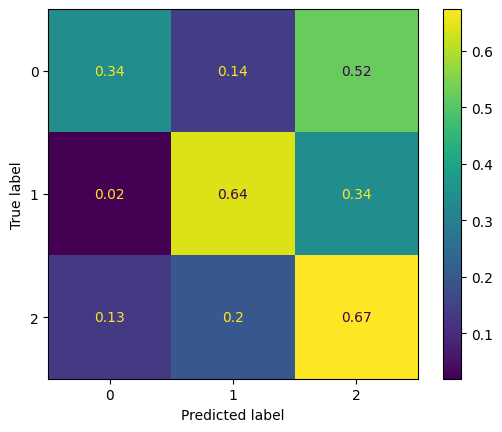

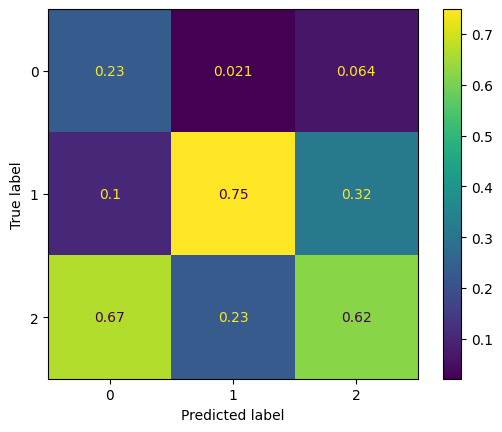

In [837]:
with torch.no_grad():
    y_pred = ironman.forward(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='true')

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='pred')


print(classification_report(y_true=y_true, y_pred=y_pred))


### **Few Things to Note Here** 📋🔍

It's interesting how the loss surface is so jagged. This is because we are sampling subsets of the data, adjusting weights according to those, and those can be good or bad samples. We'll look into this in more detail in the next mini-batch lesson. 

However, **WHOOP WHOOP!** 🎉 We got a way better F1 score! (but we had to train for much longer 🫤)

Now, let's take a look at the ensemble method with bagging. 📊🤖

In [4]:
from torch.utils.data import Subset
import numpy as np

This func samples a subset of the training data with replacement (aka bagging)

In [5]:
def sample_with_replacement(x, y):
    size = x.size()
    indices = torch.randint(0, size[0], size=size, dtype=torch.long)

    x_sampled = x[indices]
    y_sampled = y[indices]
    return x_sampled, y_sampled

### **Note on Bagging** 📂🔄

We will bag our dataset **X** into 3 different datasets and then train on these datasets as a whole. In reality, we should bag them and then train using batch sizes. That being said, you will see in **Lesson 04** all about training using mini-batches and why it is beneficial. 📚🔍


In [6]:
man00 = MANYMEN()
optimizer00 = torch.optim.AdamW(params=man00.parameters(), lr=0.0003, weight_decay=0.03)

criterion = nn.CrossEntropyLoss()


In [7]:
X_subset00, y_subset00 = sample_with_replacement(X_train, y_train)

: 

In [977]:
# Training loop
lossi00 = []
devlossi00 = []

for epoch in tqdm(range(155)):
    out00 = man00.forward(X_subset00)
    optimizer00.zero_grad()
    loss00 = criterion(out00, y_subset00)
    loss00.backward()
    optimizer00.step()
    lossi00.append(loss00.item())

    #get the loss on the test set
    with torch.no_grad():
        devout00 = man00.forward(X_test)
        devloss00 = criterion(devout00, y_test)
        devlossi00.append(devloss00.item())


    #plot the loss every 2 epochs
    if epoch % 2 == 0:
        plt.close()
        plt.plot(lossi00, label='train00')
        plt.plot(devlossi00, label='test')
        plt.legend()
        plt.savefig("loss.png")

    #quit if test loss start to get bad
    if epoch > 10 and devlossi00[-1] > devlossi00[-2]:
        break


del X_subset00, y_subset00 #clean us space in ram


  0%|          | 0/155 [00:48<?, ?it/s]


KeyboardInterrupt: 

### **Unexpected Results: Why?** 🤔

Well, things didn't go as planned. Why? Ideally, we would have learned that an ensemble of models with bagging would perform better than the Iron Man model. However, it comes at a high computational cost, and dropout can be a good approximation, especially with this mystical "mini-batching" that we haven't talked about yet.

Here, we encountered a crash because resampling a large piece of memory (the dataset) caused my RAM to crash. This is actually one of the reasons batches were created: to allow us to train on large datasets without crashing our computer. 

In the next lesson, we'll learn that not only does mini-batching help with computational efficiency, but it also helps achieve better results, as we saw with Iron Man with and without using batching. 🚀💡
